# Phase 3 Classification Project - NYC Cycling Fatalities 

## Business Problem and Overview

   Our proposed client is the City of New York itself. The city government has come under fire from constituents and cyclist advocacy groups for the dangerous conditions cyclists endure. The city's transportation leadership want to know what conditions lead to deadly traffic collisions for New York's cyclists. The classification model in this instance is not the end product, as once the city has a record of the accident, they already know if a cyclist has died or not. The final product of this analysis will be the emergent patters revealed by what parameters make for a classification model capable of predicting fatal cycling accidents.
   
   Fittingly, the City of New York is also the source of our data. Our dataset comes in the form of 1.8 million rows detailing motor vehicle collisions that have occured in NYC. The city publishes this data via the NYC Open Data project, an initiative undertaken by the city to make publicly aggregated data accessible to citizens. The data spans nearly a decade, covering dates from July 2012, and is updated almost daily. 
   
   Our dataset is highly imbalanced (99.5% - .5%) which means that using accuracy score as a default would be a mistake, as even a dummy model that simply guessed the majority class every time would have an accuracy of 99.5%. For our purposes, a metric such as recall would work much better, as judging our model on its ability to find the true positives (lethal collisions). 

## 1. Data Understanding

### 1.1 Import the Relevant Libraries, Modules, and Functions

In [2]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import plot_confusion_matrix, classification_report, roc_auc_score
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier


# This pandas option makes sure the juptyer notebook displays all the columns 
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

seed = 6

### 1.2 CSV Into Pandas Dataframe

In [3]:
# Here we read our csv into a pandas dataframe. This can take a while. 
df = pd.read_csv('../data/Motor_Vehicle_Collisions.csv', low_memory=False)

In [4]:
# df.describe()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1830092 entries, 0 to 1830091
Data columns (total 29 columns):
 #   Column                         Dtype  
---  ------                         -----  
 0   CRASH DATE                     object 
 1   CRASH TIME                     object 
 2   BOROUGH                        object 
 3   ZIP CODE                       object 
 4   LATITUDE                       float64
 5   LONGITUDE                      float64
 6   LOCATION                       object 
 7   ON STREET NAME                 object 
 8   CROSS STREET NAME              object 
 9   OFF STREET NAME                object 
 10  NUMBER OF PERSONS INJURED      float64
 11  NUMBER OF PERSONS KILLED       float64
 12  NUMBER OF PEDESTRIANS INJURED  int64  
 13  NUMBER OF PEDESTRIANS KILLED   int64  
 14  NUMBER OF CYCLIST INJURED      int64  
 15  NUMBER OF CYCLIST KILLED       int64  
 16  NUMBER OF MOTORIST INJURED     int64  
 17  NUMBER OF MOTORIST KILLED      int64  
 18  CO

### 1.3 Seperating by Cyclist Fatalities, Cyclist Injuries and Finding Distributions

In [5]:
# Lets start by finding how many collisions involved a cyclist, fatally or otherwise. 
cyclist_collisions = df.loc[ (df['NUMBER OF CYCLIST INJURED'] > 0) | (df['NUMBER OF CYCLIST KILLED'] > 0)]
len(cyclist_collisions)

43280

In [5]:
# This df is comprised of collisions where one or more cyclist were injured, but none died. 
non_lethal_collisions = df.loc[(df['NUMBER OF CYCLIST INJURED'] > 0) & (df['NUMBER OF CYCLIST KILLED'] == 0)]
len(non_lethal_collisions)

43101

In [6]:
# Next lets find how many rows record a cyclist dying. 
lethal_collisions = df.loc[df['NUMBER OF CYCLIST KILLED'] > 0]
len(lethal_collisions)

179

In [7]:
# Here we are determining how many collisions resulted in both cyclist injuries, and cyclist fatalities. 
combination_collisions = df.loc[ (df['NUMBER OF CYCLIST INJURED'] > 0) & (df['NUMBER OF CYCLIST KILLED'] > 0) ]
len(combination_collisions)

7

In [8]:
# Only one row details an event where more than one cyclist died.
print(len(df.loc[df['NUMBER OF CYCLIST KILLED'] > 1]))

# This row describes the tragic terrorist attack that occured on Halloween 2017.
df.loc[df['NUMBER OF CYCLIST KILLED'] == 2]

1


,CRASH DATE,CRASH TIME,BOROUGH,ZIP CODE,LATITUDE,LONGITUDE,LOCATION,ON STREET NAME,CROSS STREET NAME,OFF STREET NAME,NUMBER OF PERSONS INJURED,NUMBER OF PERSONS KILLED,NUMBER OF PEDESTRIANS INJURED,NUMBER OF PEDESTRIANS KILLED,NUMBER OF CYCLIST INJURED,NUMBER OF CYCLIST KILLED,NUMBER OF MOTORIST INJURED,NUMBER OF MOTORIST KILLED,CONTRIBUTING FACTOR VEHICLE 1,CONTRIBUTING FACTOR VEHICLE 2,CONTRIBUTING FACTOR VEHICLE 3,CONTRIBUTING FACTOR VEHICLE 4,CONTRIBUTING FACTOR VEHICLE 5,COLLISION_ID,VEHICLE TYPE CODE 1,VEHICLE TYPE CODE 2,VEHICLE TYPE CODE 3,VEHICLE TYPE CODE 4,VEHICLE TYPE CODE 5
687327,10/31/2017,15:08,MANHATTAN,10014,40.729046,-74.01073,"(40.729046, -74.01073)",WEST STREET,WEST HOUSTON STREET,NaN,12.0,8.0,7,6,1,2,4,0,Other Vehicular,Unspecified,Unspecified,Unspecified,Unspecified,3782508,Flat Bed,Bus,Bike,Bike,Bike


### 1.4 Counts Analysis 
    
   So out of nearly 2 million recorded traffic collisions, 43,280 involved a cyclist either getting injured, or killed. 
   
   Of those 43,280 collisions involving a cyclist, 43,101 detail a cyclist getting injured, but no cyclists dying. This means that in 99.5% of traffic collisions where a cyclist is either injured or killed, the cyclist does not die of their injuries. This is a HIGHLY imbalanced dataset, and our classifiers will need to be extremely robust to detect the minority class. 
   
   We found 179 rows detailing an incident that resulted in the death of a cyclist. Only 7 rows fell into the category of 'combination collisions' where there were both cyclist injuries, as well as cyclist deaths. These combination rows will be considered lethal collisions in our classification, as they have obvious crossed the threshold for what defines a deadly collision (more than 0 cyclist deaths). 
   
   Only one row in our entire dataset represents an event where more than one cyclist died. This row details the terrorist attack that occured on Halloween of 2017, where an attacker drove a pickup truck down the westside bike path, injuring 12, and killing 8. This tragic event is certainly an outlier in our dataset, and will not be included in our model building process, as anti-terrorist measures on seperated, dedicated bike paths is outside the scope of this project's analysis. In addition, measures to prevent this kind of event from happening again on the west side bike path have already been taken. 

In [9]:
# Isolating just the collisions involving cyclists
cyc_col = df.loc[ (df['NUMBER OF CYCLIST INJURED'] > 0) | (df['NUMBER OF CYCLIST KILLED'] > 0)]

# Dropping the 2017 terror attack from our dataframe
all_cycling_collisions = cyc_col.loc[cyc_col['NUMBER OF CYCLIST KILLED'] < 2]

# Making sure we don't have any collisions recorded twice, by dropping any duplicates in the ID column 
all_cycling_collisions.drop_duplicates(['COLLISION_ID'])

# Checking the length 
len(all_cycling_collisions)

43279

In [10]:
# We saved our cycling collisions data as its own csv, as this is really the raw dataset of interest. 

#all_cycling_collisions.to_csv('Cycling_Collisions_Isolated')

### 1.5 NaN Value Report Function 

In [11]:
# This custom function lets us check the number of NaN values for each of the columns specified in the list
def nan_report(columns):

    '''This function takes in a list of column names, and will output the count and percents of NaN values
       in each of those columns in the lethal and non-lethal dataframes.'''
    
    for col in columns:
        
        # First we will get the raw counts for the lethal collisions, then convert to %'s
        lethal_nans = (lethal_collisions[col].isna().sum())
        lethal_percent = int(round((lethal_nans / 178) * 100))
        
        # Then do the same for the non_lethal_collisions
        non_lethal_nans = (non_lethal_collisions[col].isna().sum())
        non_lethal_percent = int(round((non_lethal_nans / 43101) * 100))
        
        # Printing the results in a highly readable way
        print(f'''Column: {col.title()}
        
        Lethal Collisions:     {lethal_percent}% NaN values.
        Non-Lethal Collisions: {non_lethal_percent}% NaN values.
        
        ''')

### 1.6 Column Data and NaN Value Counts

   The first problem with much of the information in this dataset, is that it is stored in messy, irregular strings. For example under vehicle type, we see 'taxi' and 'Taxi' as seperate categories. In the date column, the dates are stored as strings, which will have to be converted, or at the very least one hot encoded into buckets if we want date to be a useful feature. 
   
   The other challenge standing in the way of this analysis is going to be dealing with all the NaN values in columns that we need for our models. With this is mind, there are two reasons why we chose to not simply drop rows with NaN values in important input columns. 

   One is that because our dataset is so incredibly imbalanced, NaN values in important columns, in rows belonging to our minority class, will significantly impede our attempt to generate a generalizable model that can identify the minority class in new unseen data. The other reason we must find a way to deal with the rows containing NaNs is that since the number of lethal collisions is so proportionally small, if we just dropped rows with NaNs in the relevant columns, we would be thinning out our already tiny minority class. 
   
   This means that our process is going to involve a lot of preprocessing, filling in the missing pieces. The first step in that process is to see what the damage is, and look at the NaN value counts for our columns.

### 1.6.1 Time and Location Data Columns


In [12]:
# Displaying the time and location columns 
all_cycling_collisions.iloc[:,:10].head(5)

,CRASH DATE,CRASH TIME,BOROUGH,ZIP CODE,LATITUDE,LONGITUDE,LOCATION,ON STREET NAME,CROSS STREET NAME,OFF STREET NAME
52,04/16/2021,11:00,QUEENS,11368,40.749580,-73.865410,"(40.74958, -73.86541)",NaN,NaN,100-10 ROOSEVELT AVENUE
90,04/14/2021,0:00,NaN,NaN,40.601864,-74.002320,"(40.601864, -74.00232)",BATH AVENUE,NaN,NaN
139,04/13/2021,17:55,BRONX,10452,40.844105,-73.923065,"(40.844105, -73.923065)",GRANT HIGHWAY,UNIVERSITY AVENUE,NaN
145,04/14/2021,19:45,BROOKLYN,11201,40.694840,-73.983910,"(40.69484, -73.98391)",FLATBUSH AVENUE EXTENSION,JOHNSON STREET,NaN
178,04/16/2021,0:30,QUEENS,11369,40.758680,-73.875520,"(40.75868, -73.87552)",93 STREET,32 AVENUE,NaN


In [13]:
# Making a list of the time and location columns, then passing them into the nan_report function
time_and_location_columns = ['CRASH DATE', 'CRASH TIME', 'BOROUGH', 'ZIP CODE', 'LATITUDE',
                             'LONGITUDE', 'LOCATION', 'ON STREET NAME', 'CROSS STREET NAME',
                             'OFF STREET NAME']

nan_report(time_and_location_columns)

Column: Crash Date
        
        Lethal Collisions:     0% NaN values.
        Non-Lethal Collisions: 0% NaN values.
        
        
Column: Crash Time
        
        Lethal Collisions:     0% NaN values.
        Non-Lethal Collisions: 0% NaN values.
        
        
Column: Borough
        
        Lethal Collisions:     27% NaN values.
        Non-Lethal Collisions: 22% NaN values.
        
        
Column: Zip Code
        
        Lethal Collisions:     27% NaN values.
        Non-Lethal Collisions: 22% NaN values.
        
        
Column: Latitude
        
        Lethal Collisions:     13% NaN values.
        Non-Lethal Collisions: 7% NaN values.
        
        
Column: Longitude
        
        Lethal Collisions:     13% NaN values.
        Non-Lethal Collisions: 7% NaN values.
        
        
Column: Location
        
        Lethal Collisions:     13% NaN values.
        Non-Lethal Collisions: 7% NaN values.
        
        
Column: On Street Name
        
     

### 1.6.2 Contributing Factor Columns

In [14]:
# Lets examine the contributing factor columns 
all_cycling_collisions.iloc[:,18:23].head(5)

,CONTRIBUTING FACTOR VEHICLE 1,CONTRIBUTING FACTOR VEHICLE 2,CONTRIBUTING FACTOR VEHICLE 3,CONTRIBUTING FACTOR VEHICLE 4,CONTRIBUTING FACTOR VEHICLE 5
52,Turning Improperly,Unspecified,NaN,NaN,NaN
90,Failure to Yield Right-of-Way,Unspecified,NaN,NaN,NaN
139,Pedestrian/Bicyclist/Other Pedestrian Error/Co...,Unspecified,NaN,NaN,NaN
145,Driver Inattention/Distraction,Driver Inattention/Distraction,NaN,NaN,NaN
178,Unsafe Speed,Unspecified,Unspecified,NaN,NaN


In [15]:
# Passing a list of the columns into our nan_report function
contributing_factor_columns = ['CONTRIBUTING FACTOR VEHICLE 1',
                               'CONTRIBUTING FACTOR VEHICLE 2',
                               'CONTRIBUTING FACTOR VEHICLE 3',
                               'CONTRIBUTING FACTOR VEHICLE 4',
                               'CONTRIBUTING FACTOR VEHICLE 5']

nan_report(contributing_factor_columns)

Column: Contributing Factor Vehicle 1
        
        Lethal Collisions:     0% NaN values.
        Non-Lethal Collisions: 0% NaN values.
        
        
Column: Contributing Factor Vehicle 2
        
        Lethal Collisions:     7% NaN values.
        Non-Lethal Collisions: 7% NaN values.
        
        
Column: Contributing Factor Vehicle 3
        
        Lethal Collisions:     87% NaN values.
        Non-Lethal Collisions: 98% NaN values.
        
        
Column: Contributing Factor Vehicle 4
        
        Lethal Collisions:     97% NaN values.
        Non-Lethal Collisions: 100% NaN values.
        
        
Column: Contributing Factor Vehicle 5
        
        Lethal Collisions:     98% NaN values.
        Non-Lethal Collisions: 100% NaN values.
        
        


### 1.6.3 Vehicle Type Code Columns

   These 5 columns contain data about the vehicles that were involved in the collision, including the Bike/E-Bike. Vehicle type could be a super important feature for our models, so we will have to deal with the messy string values, as well as NaN values. 

In [16]:
# Displaying the vehicle type code columns
all_cycling_collisions.iloc[:,24:29].head(5)

,VEHICLE TYPE CODE 1,VEHICLE TYPE CODE 2,VEHICLE TYPE CODE 3,VEHICLE TYPE CODE 4,VEHICLE TYPE CODE 5
52,Station Wagon/Sport Utility Vehicle,Bike,NaN,NaN,NaN
90,Station Wagon/Sport Utility Vehicle,Bike,NaN,NaN,NaN
139,Station Wagon/Sport Utility Vehicle,Bike,NaN,NaN,NaN
145,Sedan,Bike,NaN,NaN,NaN
178,Sedan,Bike,NaN,NaN,NaN


So just looking at these first ten rows, it becomes obvious that the majority of collisions are between a cyclist and one other vehicle, to confirm this, lets take a look at how the number of NaN values increase over the course of the five columns.

In [17]:
# Passing the type code columns into our nan_report function
vehicle_type_columns = ['VEHICLE TYPE CODE 1',
                        'VEHICLE TYPE CODE 2',
                        'VEHICLE TYPE CODE 3',
                        'VEHICLE TYPE CODE 4',
                        'VEHICLE TYPE CODE 5']

nan_report(vehicle_type_columns)

Column: Vehicle Type Code 1
        
        Lethal Collisions:     0% NaN values.
        Non-Lethal Collisions: 0% NaN values.
        
        
Column: Vehicle Type Code 2
        
        Lethal Collisions:     7% NaN values.
        Non-Lethal Collisions: 9% NaN values.
        
        
Column: Vehicle Type Code 3
        
        Lethal Collisions:     87% NaN values.
        Non-Lethal Collisions: 98% NaN values.
        
        
Column: Vehicle Type Code 4
        
        Lethal Collisions:     97% NaN values.
        Non-Lethal Collisions: 100% NaN values.
        
        
Column: Vehicle Type Code 5
        
        Lethal Collisions:     98% NaN values.
        Non-Lethal Collisions: 100% NaN values.
        
        


We can see that only 13% and 2% of the rows in our lethal, and non-lethal dataframes respectively, have values for Vehicle Type by the time we get to the third column. The string values, and the NaN values will be dealt with in the data preparation step.

## 2. Data Cleaning

### 2.1 Drop Unnecessary Columns

The first step of preprocessing is to drop the columns that are not useful for this analysis.

In [18]:
# Dropping unwanted columns using this list
all_cycling_collisions = all_cycling_collisions.drop([ 'NUMBER OF PERSONS INJURED',
                                                       'NUMBER OF PERSONS KILLED', 
                                                       'NUMBER OF PEDESTRIANS INJURED',
                                                       'NUMBER OF PEDESTRIANS KILLED',  
                                                       'NUMBER OF MOTORIST INJURED',
                                                       'NUMBER OF MOTORIST KILLED',
                                                       'COLLISION_ID' ] , axis=1)

# Making sure it worked
all_cycling_collisions.shape

(43279, 22)

### 2.2 Making the 'Lethal' Column 

Before we can seperate our training data and our holdout data, we need to make a target y column, as our two datasets currently store this information in two seperate columns. After we have created this new column, we can drop the original two. 

In [19]:
# Creating the lethality column and filling it with zeros
all_cycling_collisions['Lethal'] = 0

# Going through the data frame and marking lethal collisions
all_cycling_collisions.loc[ all_cycling_collisions['NUMBER OF CYCLIST KILLED'] > 0,['Lethal']] = 1

# Dropping the old columns
all_cycling_collisions = all_cycling_collisions.drop(['NUMBER OF CYCLIST KILLED', 'NUMBER OF CYCLIST INJURED'], axis=1)

# The all-important sanity check
all_cycling_collisions['Lethal'].value_counts()

0    43101
1      178
Name: Lethal, dtype: int64

### 2.3 Collision Year 

One of the features we want to include in our modelling process is what year the collision took place in, to do this we are going to create a new column for year, and make sure it is in a format that can be handled by SciKit-learn's OneHotEncoder( ). 

In [20]:
# Creating our year column, so we can One-Hot Encode it in a pipeline later on. 
all_cycling_collisions['Year'] = [int(date[-4:]) for date in all_cycling_collisions['CRASH DATE']]

# Checking our work 
all_cycling_collisions['Year'].value_counts()

2020    5481
2019    4964
2016    4945
2017    4864
2018    4694
2015    4266
2013    4062
2014    3999
2021    3802
2012    2202
Name: Year, dtype: int64

### 2.4 Collision Month

We are creating this column for two reasons. The first is that this information could be a very good predictor of cycling lethality, for example if icy roads contribute to cyclist deaths in the winter months. The other reason is that our models are going to need every feature we can give them if they are going to be able to identify the minority class in spite of the extreme class imbalance. Also fortunate is the fact that every single record in our dataset has an entry for 'CRASH DATE', so we dont have to deal with any NaN values. 

In [21]:
# Creating our 'Month' Column 
all_cycling_collisions['Month'] = [int(date[:2]) for date in all_cycling_collisions['CRASH DATE']]

# Checking the values 
all_cycling_collisions['Month'].value_counts()

8     5768
7     5539
9     5420
6     4819
10    4277
5     3998
11    3068
4     2817
3     2193
12    2146
1     1725
2     1509
Name: Month, dtype: int64

### 2.5 Holiday Column

To take further advantage of the lack of NaN values, we are going to engineer a Holiday Column, that tracks whether or not a collision took place on or very near to a major holiday. Unfortunately, a holiday means a predictable spike in drunk driving, and also just an increase in travel in general. This column will track collisions that took place on the most hazardous holiday travel days. 

In [22]:
# Chopping the year off of the date strings for easier syntax later
all_cycling_collisions['CRASH DATE'] = [date[:5] for date in all_cycling_collisions['CRASH DATE']]

# Making a list of the relevant dates
holiday_travel_dates = ['12/31', '01/01',
                        '05/27', '05/28', '05/29', '05/30',
                        '06/03', '06/04' , '06/05',
                        '09/05', '09/06', '09/07', 
                        '11/24', '11/25', '11/26',
                        '12/24', '12/25', '12/26',
                        '10/31', '11/1']

# Creating the column and filling it with zeros to begin with
all_cycling_collisions['Holiday Collision'] = 0

# Marking the relevant collisions
for date in holiday_travel_dates:
    all_cycling_collisions.loc[all_cycling_collisions['CRASH DATE'] == date, ['Holiday Collision']] = 1
    
# With the last of our 'CRASH DATE' based feature engineering done, we can drop it from our dataframe
all_cycling_collisions = all_cycling_collisions.drop(['CRASH DATE'], axis=1)
    
# Sanity check    
all_cycling_collisions['Holiday Collision'].value_counts()

0    41163
1     2116
Name: Holiday Collision, dtype: int64

### 2.6 Time of Day 

The hour of the day the accident occured in could have big implications in our model, and for our business problem. As it stands right now, the 'CRASH TIME' column specifies the time down to the minute, which is a more granular breakdown than our model requires. We will convert the hour and minute information into only what hour the accident occured in. Thankfully, the data is already in a 24 hour format, and there are no NaN values

In [23]:
# Getting just the hour information and storing it in a new column, 'Hour'
all_cycling_collisions['Hour'] = [int(time[:2].replace(':','')) for time in all_cycling_collisions['CRASH TIME']]

# Dropping the 'CRASH TIME' column, as we no longer need it
all_cycling_collisions = all_cycling_collisions.drop(['CRASH TIME'], axis=1)

# Sanity Check
all_cycling_collisions['Hour'].value_counts()

18    3588
17    3558
19    3306
16    3188
20    2932
14    2792
15    2715
13    2449
21    2394
12    2123
22    1825
11    1823
9     1634
8     1562
10    1477
23    1342
0     1307
7      961
6      569
1      514
2      365
5      312
3      279
4      264
Name: Hour, dtype: int64

### 2.7 Borough

Borough could turn out to be a very useful feature for our classification models, but first we have to contend with all the NaN values in that column. We know from our earlier NaN report on this column that roughly a quarter of collisions do not specify what Borough the crash took place in. 

In [24]:
# Looking at the values in the Borough Column 
print(all_cycling_collisions["BOROUGH"].value_counts())

# This dataframe is all of our rows where Borough holds a NaN value
nan_boro = all_cycling_collisions.loc[all_cycling_collisions['BOROUGH'].isna()]

# This line confirms what our NaN report told us earlier, by telling us the amount of NaN's
print(f'''
        There are {len(nan_boro)} rows with a NaN for Borough''')

# This line prints how many of our 9416 rows have latitude and longitude data
len(nan_boro) - nan_boro['LOCATION'].isna().sum()

BROOKLYN         13425
MANHATTAN         9841
QUEENS            6698
BRONX             3496
STATEN ISLAND      403
Name: BOROUGH, dtype: int64

        There are 9416 rows with a NaN for Borough


6966

The above code shows us that even though we have 9416 rows that dont specify Borough, 6966 of those rows do specify Latitude and Longitude data, which we can use to extrapolate what Borough they occured in. (Street name might be easier, or put the zip code thing before this and then use them.)

In [25]:
# Let's start by renaming the column to match the others
all_cycling_collisions['Borough'] = all_cycling_collisions['BOROUGH']
all_cycling_collisions = all_cycling_collisions.drop(['BOROUGH'], axis=1)
#
#
#
#
#
#
# WHIZ KID HOT SHIT CODE GOES RIGHT HERE
#
#
#
#
#

In [26]:
all_cycling_collisions.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 43279 entries, 52 to 1830084
Data columns (total 23 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   ZIP CODE                       33862 non-null  object 
 1   LATITUDE                       40041 non-null  float64
 2   LONGITUDE                      40041 non-null  float64
 3   LOCATION                       40041 non-null  object 
 4   ON STREET NAME                 37065 non-null  object 
 5   CROSS STREET NAME              31453 non-null  object 
 6   OFF STREET NAME                6145 non-null   object 
 7   CONTRIBUTING FACTOR VEHICLE 1  43261 non-null  object 
 8   CONTRIBUTING FACTOR VEHICLE 2  40195 non-null  object 
 9   CONTRIBUTING FACTOR VEHICLE 3  992 non-null    object 
 10  CONTRIBUTING FACTOR VEHICLE 4  107 non-null    object 
 11  CONTRIBUTING FACTOR VEHICLE 5  35 non-null     object 
 12  VEHICLE TYPE CODE 1            43259 non-nu

### 2.8 Zip Code 

We definitely want to feed this feature into our model, as it could help our classificaiton algorithm perform better. 

In [27]:
# This is how many rows do not contain Zip Code information
print(sum(all_cycling_collisions['ZIP CODE'].isna()))

# Of those 9417 rows that dont have zipcode data, only 2450 also do not have latitude and longitude 
len(all_cycling_collisions.loc[all_cycling_collisions['ZIP CODE'].isna() & all_cycling_collisions['LOCATION'].isna()])

9417


2450

What the above numbers mean is that if we can find a way to get the zipcode from the Latitude and Longitude, we can fill in three quarters of our missing zip codes. 

In [28]:
# Let's rename our column so we can tell it's been processed 
all_cycling_collisions.loc[all_cycling_collisions['ZIP CODE'].isna(), ['ZIP CODE']] = 0
all_cycling_collisions['Zip Code'] = [int(zipcode) for zipcode in all_cycling_collisions['ZIP CODE'] ]

#
#
#
#
#
#
# ZIP CODE WIZARDY GOES HERE, STACK OVERFLOW PAGE HAS BEEN BOOKMARKED
#
#
#
#
#
#
#

# Now that we are finished with the Location-Based columns, we can drop the originals 
all_cycling_collisions = all_cycling_collisions.drop(['ZIP CODE', 'LATITUDE', 'LONGITUDE', 'LOCATION'], axis=1)

### 2.9 Street Name

If it becomes a strong predictor, street name could be an essential feature for our business problem, as it would tell the city which streets are the most dangerous for cyclists, and therefore where to focus their efforts in terms of building new infrastructure. Street name in our dataset comes in the form of three columns, ON STREET NAME, CROSS STREET NAME, and OFF STREET NAME. The values in these columns are fairly clean in their formatting, and dont exhibit any significant overlap or redundancy.

In [29]:
# This dataframe contains the rows with no street data whatsoever
no_street_data = all_cycling_collisions.loc[all_cycling_collisions['ON STREET NAME'].isna() & 
                                            all_cycling_collisions['CROSS STREET NAME'].isna() &
                                            all_cycling_collisions['OFF STREET NAME'].isna()]

# Luckily only 61 rows of our entire dataframe contain zero street name values
print(f'There are {len(no_street_data)} rows without any street name data.')

There are 61 rows without any street name data.


Now we are finding the columns with NaN values under Cross Street, and filling them in with the values from OFF STREET NAME, if there are any. 

In [30]:
# Renaming our two columns 
all_cycling_collisions['Street'] = all_cycling_collisions['ON STREET NAME']
all_cycling_collisions['Cross Street'] = all_cycling_collisions['CROSS STREET NAME']

# Check how many NaN values we have in Cross Street before meshing it with OFF STREET NAME
print(len(all_cycling_collisions.loc[all_cycling_collisions['Cross Street'].isna()]))

# For our columns without a listed Cross Street, we are using the OFF STREET NAME value, if it has one
all_cycling_collisions.loc[all_cycling_collisions['Cross Street'].isna(), ['Cross Street']] = all_cycling_collisions['OFF STREET NAME']

# Number of NaNs in Cross Street after the merge
print(len(all_cycling_collisions.loc[all_cycling_collisions['Cross Street'].isna()]))

# Drop the old columns 
all_cycling_collisions = all_cycling_collisions.drop(['ON STREET NAME','CROSS STREET NAME','OFF STREET NAME'],axis=1)

11826
5681


### 2.10 Intersection (maybe)


In [31]:
#
#
#
#
#
#
#
# Come back and possibly add an intersection feature here later
#
#
#
#
#
#
#
#
#

### 2.10 Contributing Factor Columns 



In [32]:
#all_cycling_collisions['CONTRIBUTING FACTOR VEHICLE 1'].value_counts()
all_cycling_collisions['Factor 1'] = 'Contributing Factor Unknown'

### 2.11 Vehicle Type Codes 



In [33]:
#all_cycling_collisions['VEHICLE TYPE CODE 1'].value_counts()
all_cycling_collisions['Vehicle Type'] = 'Vehicle Type Unknown'

In [34]:
# Delete this cell later
all_cycling_collisions.drop(['CONTRIBUTING FACTOR VEHICLE 1', 'CONTRIBUTING FACTOR VEHICLE 2',
       'CONTRIBUTING FACTOR VEHICLE 3', 'CONTRIBUTING FACTOR VEHICLE 4',
       'CONTRIBUTING FACTOR VEHICLE 5', 'VEHICLE TYPE CODE 1',
       'VEHICLE TYPE CODE 2', 'VEHICLE TYPE CODE 3', 'VEHICLE TYPE CODE 4',
       'VEHICLE TYPE CODE 5'], axis=1, inplace=True)

## 3. Data Preprocessing

### 3.1 Train Test Split

The absolute first thing we need to do in terms of preprocessing is to seperate our data into the train and holdout set to avoid data leakage, and make sure we can robustly evaluate our models later on. 

In [35]:
# Seperating our data into features and target
X = all_cycling_collisions.drop(['Lethal'], axis=1)
y = all_cycling_collisions['Lethal']

# Performing the split
X_train, X_hold, y_train, y_hold = train_test_split(X, y, random_state=seed, test_size=.15)

### 3.2 Imputing Missing Values 

In [36]:
X_train.loc[X_train['Borough'].isna(), ['Borough'] ] = 'No Borough'
X_train.loc[X_train['Street'].isna(),  ['Street'] ]  = 'No Street'
X_train.loc[X_train['Street'].isna(),  ['Street'] ]  = 'No Street'
X_train.loc[X_train['Cross Street'].isna(),  ['Cross Street'] ]  = 'No Cross Street'
X_train.loc[X_train['Zip Code'].isna(),['Zip Code']] = 'No Zip Code'

/Users/aidanstack/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/pandas/core/indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


In [37]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 36787 entries, 449836 to 1222642
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Year               36787 non-null  int64 
 1   Month              36787 non-null  int64 
 2   Holiday Collision  36787 non-null  int64 
 3   Hour               36787 non-null  int64 
 4   Borough            36787 non-null  object
 5   Zip Code           36787 non-null  object
 6   Street             36787 non-null  object
 7   Cross Street       36787 non-null  object
 8   Factor 1           36787 non-null  object
 9   Vehicle Type       36787 non-null  object
dtypes: int64(4), object(6)
memory usage: 3.1+ MB


### 3.3 One Hot Encoding

In [38]:
X_train = pd.get_dummies(X_train, columns=['Year', 'Month', 'Holiday Collision', 'Hour', 'Borough'])

In [39]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 36787 entries, 449836 to 1222642
Data columns (total 59 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   Zip Code               36787 non-null  object
 1   Street                 36787 non-null  object
 2   Cross Street           36787 non-null  object
 3   Factor 1               36787 non-null  object
 4   Vehicle Type           36787 non-null  object
 5   Year_2012              36787 non-null  uint8 
 6   Year_2013              36787 non-null  uint8 
 7   Year_2014              36787 non-null  uint8 
 8   Year_2015              36787 non-null  uint8 
 9   Year_2016              36787 non-null  uint8 
 10  Year_2017              36787 non-null  uint8 
 11  Year_2018              36787 non-null  uint8 
 12  Year_2019              36787 non-null  uint8 
 13  Year_2020              36787 non-null  uint8 
 14  Year_2021              36787 non-null  uint8 
 15  Month_1     

In [40]:
X_train.head()

,Zip Code,Street,Cross Street,Factor 1,Vehicle Type,Year_2012,Year_2013,Year_2014,Year_2015,Year_2016,Year_2017,Year_2018,Year_2019,Year_2020,Year_2021,Month_1,Month_2,Month_3,Month_4,Month_5,Month_6,Month_7,Month_8,Month_9,Month_10,Month_11,Month_12,Holiday Collision_0,Holiday Collision_1,Hour_0,Hour_1,Hour_2,Hour_3,Hour_4,Hour_5,Hour_6,Hour_7,Hour_8,Hour_9,Hour_10,Hour_11,Hour_12,Hour_13,Hour_14,Hour_15,Hour_16,Hour_17,Hour_18,Hour_19,Hour_20,Hour_21,Hour_22,Hour_23,Borough_BRONX,Borough_BROOKLYN,Borough_MANHATTAN,Borough_No Borough,Borough_QUEENS,Borough_STATEN ISLAND
449836,11357,PARSONS BOULEVARD,20 AVENUE,Contributing Factor Unknown,Vehicle Type Unknown,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0
1805592,10028,LEXINGTON AVENUE,EAST 86 STREET,Contributing Factor Unknown,Vehicle Type Unknown,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0
264722,0,5 AVENUE,No Cross Street,Contributing Factor Unknown,Vehicle Type Unknown,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0
1024088,11206,THROOP AVENUE,WALLABOUT STREET,Contributing Factor Unknown,Vehicle Type Unknown,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0
61948,0,RUGBY ROAD,No Cross Street,Contributing Factor Unknown,Vehicle Type Unknown,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0


### 3.something label encoding borough

In [41]:
label = LabelEncoder()
X_train['Zip Code']     = label.fit_transform(X_train['Zip Code'])
X_train['Street']       = label.fit_transform(X_train['Street'])
X_train['Cross Street'] = label.fit_transform(X_train['Cross Street'])
X_train['Factor 1']     = label.fit_transform(X_train['Factor 1'])

In [42]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 36787 entries, 449836 to 1222642
Data columns (total 59 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   Zip Code               36787 non-null  int64 
 1   Street                 36787 non-null  int64 
 2   Cross Street           36787 non-null  int64 
 3   Factor 1               36787 non-null  int64 
 4   Vehicle Type           36787 non-null  object
 5   Year_2012              36787 non-null  uint8 
 6   Year_2013              36787 non-null  uint8 
 7   Year_2014              36787 non-null  uint8 
 8   Year_2015              36787 non-null  uint8 
 9   Year_2016              36787 non-null  uint8 
 10  Year_2017              36787 non-null  uint8 
 11  Year_2018              36787 non-null  uint8 
 12  Year_2019              36787 non-null  uint8 
 13  Year_2020              36787 non-null  uint8 
 14  Year_2021              36787 non-null  uint8 
 15  Month_1     

## 4. Modeling 

### 4.1 Dummy Model 

The dummy model has an accuracy of 0.9959950708564387
The dummy model has a recall of 0.0


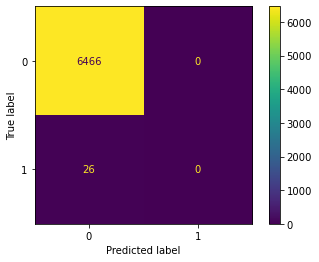

In [43]:
# Instantiating our Dummy Model and fitting it to our training data
clf_1 = DummyClassifier(strategy='most_frequent')
clf_1.fit(X_train, y_train)
dummy_pred = clf_1.predict(X_hold)

# Looking at the confusion matrix
plot_confusion_matrix(clf_1, X_hold, y_hold)

# Looking at accuracy 
print(f'The dummy model has an accuracy of {accuracy_score(y_hold, dummy_pred)}')

# But what about recall 
print(f'The dummy model has a recall of {recall_score(y_hold, dummy_pred)}')

### 4.2 Baseline Model - Basic Logistic Regression 

   This will serve as our baseline model to compare the performance of our later model iterations to. 

In [44]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 36787 entries, 449836 to 1222642
Data columns (total 59 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   Zip Code               36787 non-null  int64 
 1   Street                 36787 non-null  int64 
 2   Cross Street           36787 non-null  int64 
 3   Factor 1               36787 non-null  int64 
 4   Vehicle Type           36787 non-null  object
 5   Year_2012              36787 non-null  uint8 
 6   Year_2013              36787 non-null  uint8 
 7   Year_2014              36787 non-null  uint8 
 8   Year_2015              36787 non-null  uint8 
 9   Year_2016              36787 non-null  uint8 
 10  Year_2017              36787 non-null  uint8 
 11  Year_2018              36787 non-null  uint8 
 12  Year_2019              36787 non-null  uint8 
 13  Year_2020              36787 non-null  uint8 
 14  Year_2021              36787 non-null  uint8 
 15  Month_1     

In [45]:
X_train.head()

,Zip Code,Street,Cross Street,Factor 1,Vehicle Type,Year_2012,Year_2013,Year_2014,Year_2015,Year_2016,Year_2017,Year_2018,Year_2019,Year_2020,Year_2021,Month_1,Month_2,Month_3,Month_4,Month_5,Month_6,Month_7,Month_8,Month_9,Month_10,Month_11,Month_12,Holiday Collision_0,Holiday Collision_1,Hour_0,Hour_1,Hour_2,Hour_3,Hour_4,Hour_5,Hour_6,Hour_7,Hour_8,Hour_9,Hour_10,Hour_11,Hour_12,Hour_13,Hour_14,Hour_15,Hour_16,Hour_17,Hour_18,Hour_19,Hour_20,Hour_21,Hour_22,Hour_23,Borough_BRONX,Borough_BROOKLYN,Borough_MANHATTAN,Borough_No Borough,Borough_QUEENS,Borough_STATEN ISLAND
449836,149,2530,1702,0,Vehicle Type Unknown,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0
1805592,27,2166,6916,0,Vehicle Type Unknown,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0
264722,0,426,8229,0,Vehicle Type Unknown,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0
1024088,111,2965,9188,0,Vehicle Type Unknown,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0
61948,0,2719,8229,0,Vehicle Type Unknown,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0


In [46]:
X_train_logreg = X_train.drop(['Vehicle Type', 'Factor 1', 'Cross Street', 'Street', 'Zip Code', 'Borough'], axis=1)

clf_2 = LogisticRegression(random_state=seed)
clf_2.fit(X_train_logreg, y_train)
plot_confusion_matrix(clf_2, X_train_logreg, y_train)

KeyError: "['Borough'] not found in axis"

### 4.3 Decision Tree

In [ ]:
clf_3 = DecisionTreeClassifier(random_state=seed)
clf_3.fit(X_train, y_train)

X_train.info()